# Real Estate Valuation with Bagging and AdaBoost

In this Notebook I am going to use machine learning models for performing Real Estate Valuation. The dataset was extracted of the University of California Irvine Machine Learning Repository. In the major part of the NoteBook I will focus on the analyist part. For the Machine Learning modeling, I will use two principal algorithms: Bootstrap Aggregating (Bagging) and AdaBoost. This is a regression problem, where the goal is to predict the price of a House. The data was collected from the Taiwan Market. The code is the followed: 

# 1. Getting started

The Python Libraries:

In [1]:
#Libraries
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection  import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

The dataset is stored in an Excel file. Therefore, I am going to use Pandas for reading and storing the file in a Pandas DataFrame:

In [2]:
#Leer el archivo excel
dataset = pd.read_excel("C:/Diego/Estudio/General y obras/PYTHON PROGRAMACION/POO/Machine Learning/Task in dataset/Real Estate Valuation/Real.xlsx")

# 2. Data Exploration

In this line we are understanding our data and the principal features:

In [3]:
dataset.head()

,No,transaction date,house age,distance MRT,number of stores,latitude,longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


This is a small dataset actually. The label of the columns (name of features) was changed for the sake of simplicity. On the other hand, the explanation about the features is:

1. transaction date = date of the actual transaction (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)

2. house age = age of the house (unit: year)

3. distance MRT = the distance to the nearest MRT (Mass Rapid Transit: Public Transportation) station (unit: meter)

4. number of stores = the number of convenience stores in the living circle on foot (integer)

5. latitude = the geographic coordinate, latitude (unit: degree)

6. longitude = the geographic coordinate, longitude (unit: degree)

7. Y = house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)


Since the dataset is already clean, we are ready for the data analysis.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
No                            414 non-null int64
transaction date              414 non-null float64
house age                     414 non-null float64
distance MRT                  414 non-null float64
number of stores              414 non-null int64
 latitude                     414 non-null float64
 longitude                    414 non-null float64
Y house price of unit area    414 non-null float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


# 3. Data Analysis

For the Data Analyisis we are just considering the features "house age", "distance MRT", "number of stores" and the target Y "Y house price of unit area". I know that with a bit of feature engineering we could extract a bunch of information from "transaction date","latitude" and "longitude", but this is not the goal for now.

First of all, let's visualize the distribution of the house price of unit area (Y). We can see that the majority of price are between 20 and 60:

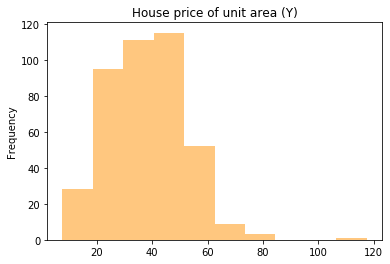

In [5]:
#House prices (Target aka Y)
House_Price = dataset["Y house price of unit area"]
House_Price.plot(x="Y house price of unit area", title = "House price of unit area (Y)" , kind="hist", colormap="copper_r")
plt.show()

Moreover, the houses age does not have seem any pattern. The age of houses of the dataset varies from 0 up to 40: 

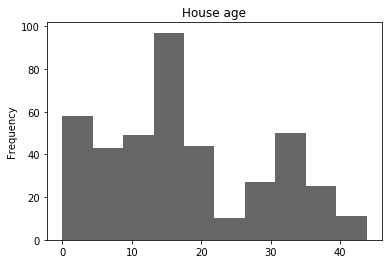

In [6]:
#House age
House_Age = dataset["house age"]
House_Age.plot(x="house age", title = "House age", kind="hist", colormap="Accent_r")
plt.show()

On the other hand, around 300 houses are somewhere between 1 and 1000 meters near of a MRT station: 

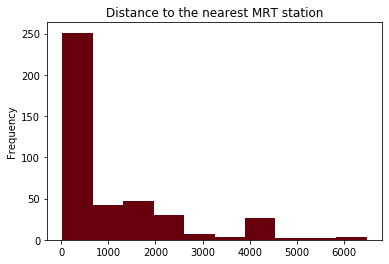

In [7]:
#Distance MRT
House_Distance = dataset["distance MRT"]
House_Distance.plot(x="distance MRT", title="Distance to the nearest MRT station", kind ="hist", colormap="Reds_r")
plt.show()

The number of convenience stores in the living circle of the houses is between 1 and 10: 

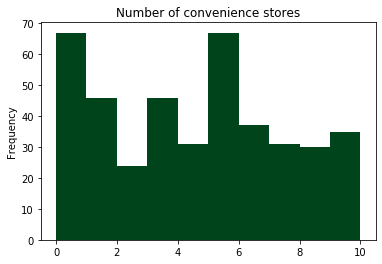

In [8]:
#Number of stores
House_Stores = dataset["number of stores"]
House_Stores.plot(x="number of stores", title="Number of convenience stores", kind="hist", colormap="Greens_r")
plt.show()

Here is the Scatter Matrix of the features. Although there is a little relationship between some features, we just can not afford drop more features, because there is a high risk that not be able to make predictions at all.

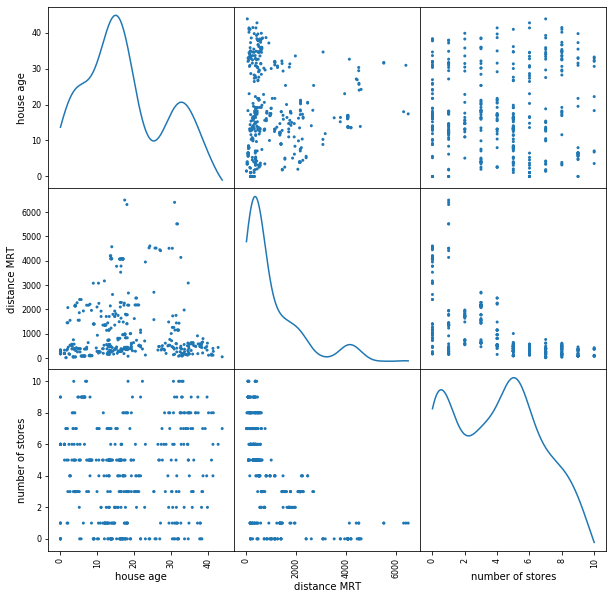

In [9]:
#Scatter Matrix
Matrix = dataset[["house age","distance MRT","number of stores"]]
pd.plotting.scatter_matrix(Matrix, diagonal="kde", range_padding=0.15, figsize=(10,10), alpha=1)
plt.show()

Here we can see a general description that can easily summarize and extend our current anaylisis:

In [10]:
dataset.describe()

,No,transaction date,house age,distance MRT,number of stores,latitude,longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Now let's explore the relationship between the house prices and each feature.

For house prices and house ages we can not observe visually any correlation. Again, we can not just drop the entire colum because the number of features is too low. 

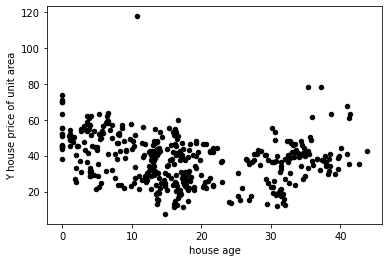

In [11]:
#House prices and house age
House_Price_Plus_House_Age = dataset[["Y house price of unit area","house age"]]
House_Price_Plus_House_Age.plot(x="house age", y="Y house price of unit area", kind="scatter", color="black")
plt.show()

In contrast, for house prices and the distance of the nearest MRT station, the correlation seems very high. This mean that the more nearness with a MRT station, the more is the house price. 

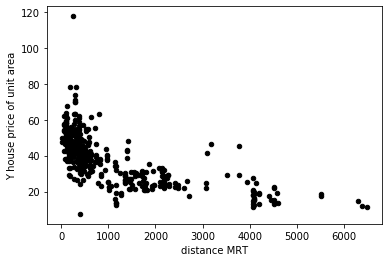

In [12]:
#House prices and distance MRT
House_Price_Plus_House_Distance = dataset[["Y house price of unit area","distance MRT"]]
House_Price_Plus_House_Distance.plot(x="distance MRT", y="Y house price of unit area", kind="scatter", color="black")
plt.show()

And finally, for house prices and number of convinience stores, the correlation is just little. Almost there is not relationship between these two features.

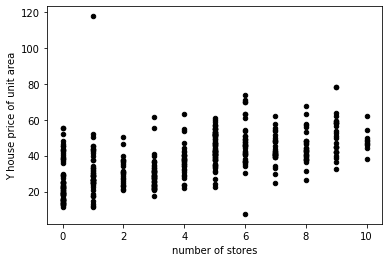

In [13]:
#House price and number of stores
House_Price_Plus_House_Stores = dataset[["Y house price of unit area","number of stores"]]
House_Price_Plus_House_Stores.plot(x="number of stores", y="Y house price of unit area", kind="scatter", color="black")
plt.show()

# 4. Modeling

Before of starting the modeling section, we need to separate the predictors (X) from the target (y):

In [14]:
#Separation of X and y
y = dataset["Y house price of unit area"]
X = dataset[["house age","distance MRT","number of stores"]]

Now, we have to split the whole dataset in training and test set:

In [15]:
#Splitting the dasatet
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.20)

The next step is importing a Bagging Regressor from sklearn and fitting with our data:

In [16]:
#Using a Bagging Regressor
Bagging = BaggingRegressor(random_state=0, n_estimators=10)
Bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)

And we have to do the same with an AdaBoost Regressor:

In [17]:
#Using an AdaBoost Regressor
AdaBoost = AdaBoostRegressor(random_state=0, n_estimators=10)
AdaBoost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=10, random_state=0)

# 5. Results

# 5.1 Predictions and Accuracy

Finally, these are the predictions and the score given for the Bagging model:

In [18]:
#Prediction of the houses price using Baggin
Test_Set_Prediction_Bagging =  Bagging.predict(X_test)
print("House prices prediction: ")
print(Test_Set_Prediction_Bagging)
print("\n")

#Accuracy of Bagging
Test_Set_Score_Bagging = Bagging.score(X_test, y_test)
print("Accuracy: ")
print(Test_Set_Score_Bagging)

House prices prediction: 
[47.105      17.25       49.28       18.99       35.486      41.99
 41.31       39.44       73.40666667 36.84       41.4        36.56333333
 33.88       41.43       58.175      51.77       35.25       44.71844048
 41.4        45.35       52.33       29.41       25.77       50.94466667
 52.71       38.48       40.22       21.04       53.5        32.36
 55.54190476 27.82       49.3        39.21       39.38       28.84
 48.68       26.62       51.46       11.7        53.18       37.79
 25.97       48.16       15.89       53.13       38.75       13.38
 27.47       53.6        60.98       33.53       58.42       17.43
 29.41       39.45       56.52       35.47       40.12       27.82
 45.21       60.235      33.13       49.40166667 40.94       25.23
 19.81       18.1        56.59       41.99       23.11       52.92
 56.16       25.74       35.97       29.16666667 26.86       17.41933333
 48.33       38.4        52.39       27.415      35.41      ]


Accuracy: 
0.71

As with the Bagging model, here we see the results for the AdaBoost model:

In [19]:
#Prediction of the houses price using AdaBoost
Test_Set_Prediction_AdaBoost =  AdaBoost.predict(X_test)
print("House prices prediction: ")
print(Test_Set_Prediction_AdaBoost)
print("\n")

#Accuracy of AdaBoost
Test_Set_Score_AdaBoost = AdaBoost.score(X_test, y_test)
print("Accuracy: ")
print(Test_Set_Score_AdaBoost)

House prices prediction: 
[44.22105263 24.09714286 45.30980392 24.09714286 41.41818182 39.08533333
 44.59827586 38.35777778 50.82380952 39.55434783 44.22105263 39.94090909
 41.41818182 44.22105263 54.39130435 39.94090909 39.08533333 48.56597938
 39.27582418 44.59827586 54.39130435 33.92083333 26.77460317 44.22105263
 45.13555556 39.94090909 39.08533333 26.77460317 45.13555556 31.2260274
 55.83283582 31.2260274  54.39130435 39.08533333 39.08533333 32.05079365
 45.30980392 31.2260274  50.82380952 24.09714286 50.82380952 39.08533333
 28.20243902 45.30980392 26.77460317 50.82380952 39.08533333 26.77460317
 31.2260274  53.39285714 54.39130435 39.27582418 45.30980392 26.77460317
 33.92083333 39.08533333 45.13555556 39.08533333 44.22105263 31.2260274
 39.27582418 56.49655172 39.27582418 50.82380952 44.22105263 26.77460317
 24.09714286 26.77460317 45.13555556 39.08533333 26.77460317 45.13555556
 45.30980392 28.20243902 39.08533333 31.2260274  31.2260274  26.77460317
 44.22105263 31.2260274  44

# 5.2 Learning Curves

Basically, a Learning Curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much a Machine Learning model benefits from adding more training data and whether the estimator suffers more from a variance error or a bias error.

This the Learning Curve of the Bagging Regressor:

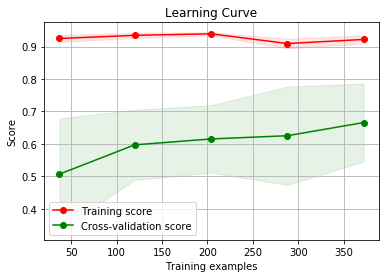

In [20]:
#Learning curve of Bagging
skplt.estimators.plot_learning_curve(Bagging, X, y, cv=10)
plt.show()

And this is the same for the AdaBoost Regressor:

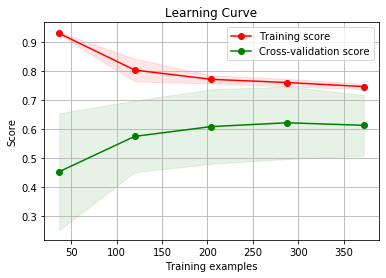

In [21]:
#Learning curve of AdaBoost
skplt.estimators.plot_learning_curve(AdaBoost, X, y, cv=10)
plt.show()

Based on the Learning Curve of the Bagging Regressor, we can conclude that the Bagging model would slightly benefit from adding more data. This is true because both lines are more separated from each other than the same lines in the AdaBoost model. On the other hand, it seems that AdaBoost would reach it limits soon if we add much more data (in learning terms). Therefore, AdaBoost will not benefit so much by adding more data.   